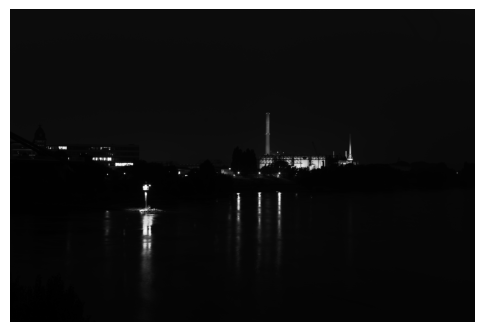

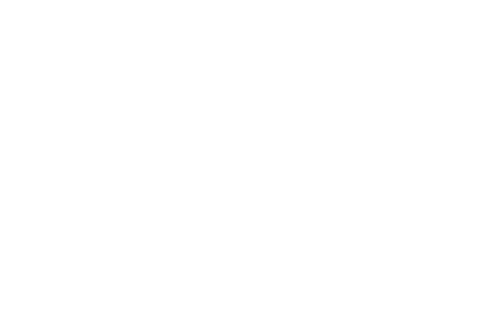

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Step 0: Convert RAW file to TIFF
# TODO 0: Fill in the following scalars with a "reconnaissance run".
# 'black': the black point in the RAW image
black = 0
# 'saturation': This is the value at which the sensor can no longer produce any higher values.
# This is _not_ anything to do with 'saturation' in terms of color spaces, e.g., HSV color space.
saturation = 16383  
# 'wb_multipliers': white balance multipliers for each of the R, G, B channels
wb_multipliers = [2.217041, 1.000000, 1.192484]

# Use the output file from command "dcraw -4 -D -T <raw_file_name>"
raw_data = Image.open('imageTp6.tiff')
# The line below should display a blank image.
#raw_data.show()

plt.figure(figsize=(6,6))
plt.imshow(np.array(raw_data).astype(np.double), cmap='gray', vmin=0, vmax=saturation) # remove cmap for RGB
plt.axis('off')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(np.array(raw_data).astype(np.double), cmap='gray', vmin=0, vmax = 1)
plt.axis('off')
plt.show()

raw = np.array(raw_data).astype(np.double)

In [ ]:
"""
En esta seccion del codigo primero se setean las constantes que se consiguen al analizar la imagen utilizando 
el siguiente comando de dcraw:
                                    dcraw -v -4 -d -T <raw_file_name>

luego abro la imagen tiff generada por dcraw y la convierto a un array de numpy para poder mostrarla 
con plt en los dos casos primero cuando los valores van de 0 a saturation y luego cuando el maximo valor es 1.
Es decir en el segundo todos los valores mayores a 1 se vuelven 1.

Luego de esto el array se guarda en la variable raw para su posterior procesamiento.
"""

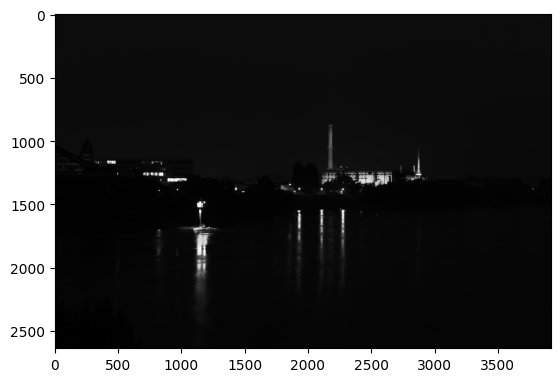

In [6]:
# # Step 1: Normalization
# # TODO 1: Map raw to range [0,1].
# Use 'raw' (set in the first cell) and normalize to [0,1]
linear_bayer = np.clip((raw - black) / (saturation - black), 0.0, 1.0)

plt.imshow(linear_bayer, cmap='gray')
plt.show()

In [ ]:
"""
    En esta seccion del codigo se normaliza la imagen raw utilizando las constantes black y saturation
    para asi se muestra la imagen normalizada en escala de grises.
    La imagen se guarda en la variable linear_bayer para su posterior procesamiento.    
"""

In [13]:
def wbscalematrix(m, n, wb_scales, align):
    # Makes a white-balance scaling matrix for an image of size m-by-n
    # from the individual RGB white balance scalar multipliers [wb_scales] = [R_scale G_scale B_scale].
    #
    # [align] is string indicating the 2x2 Bayer arrangement: 
    # 'rggb':  
    #    R G 
    #    G B 
    # 'gbrg':
    #    G B
    #    R G
    # 'grbg','bggr' follow as before.
    #
    # 

    # First, for convenience only, we're going to fill the scale matrix
    # with all green pixels. Then, we're going to replace the red and blue 
    # pixels later on with the correct scalars.
    #
    scalematrix = wb_scales[1] * np.ones((m,n)) # Initialize to all green values

    # Fill in the scales for the red and blue pixels across the matrix
    if (align == 'rggb'):
        scalematrix[0::2, 0::2] = wb_scales[0] # r
        scalematrix[1::2, 1::2] = wb_scales[2] # b
    elif (align == 'bggr'):
        scalematrix[1::2, 1::2] = wb_scales[0] # r
        scalematrix[0::2, 0::2] = wb_scales[2] # b
    elif (align == 'grbg'):
        scalematrix[0::2, 1::2] = wb_scales[0] # r
        scalematrix[1::2, 0::2] = wb_scales[2] # b
    elif (align == 'gbrg'):
        scalematrix[1::2, 0::2] = wb_scales[0] # r
        scalematrix[0::2, 1::2] = wb_scales[2] # b
    return scalematrix

In [ ]:
"""
Esta funcion genera una matriz de escala de balance de blancos para una imagen de tamaño m por n
que luego se llena de los valores de escala correspondien a cada color para la disposicion correspondiente.
"""

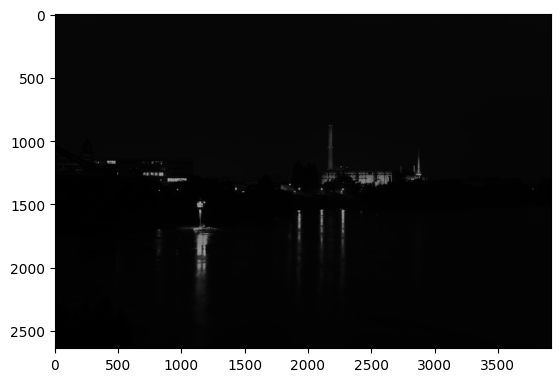

In [14]:
# # Step 2: White balancing
# # TODO 2: Complete the function wbmask().
mask = wbscalematrix(linear_bayer.shape[0], linear_bayer.shape[1], wb_multipliers, 'rggb')
balanced_bayer = np.multiply(linear_bayer, mask)

plt.imshow(balanced_bayer, cmap='gray')
plt.show()

In [ ]:
"""
Esta seccion genera la mascara de balance de blancos utilizando la funcion wbscalematrix y luego
la aplica a la imagen normalizada linear_bayer para obtener la imagen balanceada balanced_bayer.
"""

In [15]:
def apply_cmatrix(img, cmatrix):
    # Applies color transformation CMATRIX to RGB input IM. 
    # Finds the appropriate weighting of the old color planes to form the new color planes, 
    # equivalent to but much more efficient than applying a matrix transformation to each pixel.
    if (img.shape[2] != 3):
        raise ValueError('Apply cmatrix to RGB image only.')

    r = cmatrix[0,0] * img[:,:,0] + cmatrix[0,1] * img[:,:,1] + cmatrix[0,2] * img[:,:,2]
    g = cmatrix[1,0] * img[:,:,0] + cmatrix[1,1] * img[:,:,1] + cmatrix[1,2] * img[:,:,2]
    b = cmatrix[2,0] * img[:,:,0] + cmatrix[2,1] * img[:,:,1] + cmatrix[2,2] * img[:,:,2]
    corrected = np.stack((r,g,b), axis=2)
    return corrected


def debayering(input):
    # Bilinear Interpolation of the missing pixels
    #
    # Assumes a Bayer CFA in the 'rggb' layout
    #   R G R G
    #   G B G B
    #   R G R G
    #   G B G B
    #
    # Input: Single-channel rggb Bayered image
    # Returns: A debayered 3-channels RGB image
    #
    img = input.astype(np.double)

    m = img.shape[0]
    n = img.shape[1]

    # First, we're going to create indicator masks that tell us
    # where each of the color pixels are in the bayered input image
    # 1 indicates presence of that color, 0 otherwise
    red_mask = np.tile([[1,0],[0,0]], (int(m/2), int(n/2)))

    # TODO: Complete the following two lines to generate 
    # indicator masks for the green and blue channels

    green_mask = np.tile([[0,1],[1,0]], (int(m/2), int(n/2)))
    blue_mask = np.tile([[0,0],[0,1]], (int(m/2), int(n/2)))

    r = np.multiply(img, red_mask)
    g = np.multiply(img, green_mask)
    b = np.multiply(img, blue_mask)

    # Confirm for yourself: 
    # - What are the patterns of values in the r,g,b images?
    # Sketch them out to help yourself.

    # Next, we're going to fill in the missing values in r,g,b
    # For this, we're going to use filtering - convolution - to implement bilinear interpolation.
    # - We know that convolution allows us to perform a weighted sum
    # - We know _where_ our pixels lie within a grid, and where the missing pixels are
    # - We know filters come in odd sizes

    # Interpolating green:
    filter_g = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_g = convolve2d(g, filter_g, 'same')
    g = g + missing_g

    # To conceptualize how this works, let's continue to draw it out on paper.
    # - Sketch the first 5 rows and columns of the g image
    # - Sketch the 3x3 filter and add the numeric weights (they sum to 1)
    # - Sketch the output image

    # Move the filter through the valid region of the image.
    # - What is the output at pixel 1,1 ?  [0-index, remember]
    # - What is the output at pixel 2,1 ?
    # - What is the output at pixel 3,1 ?
    # - What is the output at pixel 1,2 ?
    # - What is the output at pixel 2,2 ?
    # - What is the output at pixel 3,2 ?

    # See how it works? 
    # The filter only produces output if the surrounding pixels match its pattern.
    # When they do, it produces their mean value.

    # Note that we're going to have some incorrect values at the image boundaries, 
    # but let's ignore that for this exercise.

    # Now, let's try it for blue. This one is a two-step process.
    # - Step 1: We fill in the 'central' blue pixel in the location of the red pixel
    # - Step 2: We fill in the blue pixels at the locations of the green pixels, 
    #           similar to how the green interpolation worked, but offset by a row/column
    #
    # Sketch out the matrices to help you follow.
    # Remember, we'll still have some incorrect value at the image boundaries.

    # Interpolating blue:
    # Step 1:
    filter1 = 0.25 * np.array([[1,0,1],[0,0,0],[1,0,1]])
    missing_b1 = convolve2d(b, filter1, 'same')
    # Step 2:
    filter2 = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_b2 = convolve2d(b + missing_b1, filter2, 'same')
    b = b + missing_b1 + missing_b2

    # OK! Only red left.
    
    # R G R G R G R G
    # G B G B G B G B
    # R G R G R G R G
    # G B G B G B G B

    # Interpolation for the red at the missing points
    # TODO: Complete the following two lines. Follow a similar strategy to the blue channel.
    missing_r1 = convolve2d(r, filter1, 'same') # Fills in red at blue locations
    missing_r2 = convolve2d(r + missing_r1, filter2, 'same') # Fills in red at green locations
    r = r + missing_r1 + missing_r2

    output = np.stack((r,g,b), axis=2)
    return output

In [ ]:
"""
La primer funcion aplica una matriz de transformacion de color a una imagen RGB de entrada.

La segunda funcion realiza el debayering de la imagen balanceada balanced_bayer utilizando interpolacion bilineal
para obtener la imagen RGB debayered_rgb. 

Esta funcion primero genera las mascaras de cada canal de color (rojo, verde y azul) para luego
llenar los valores faltantes en cada canal utilizando convoluciones con filtros.
"""

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.1998546356589146].


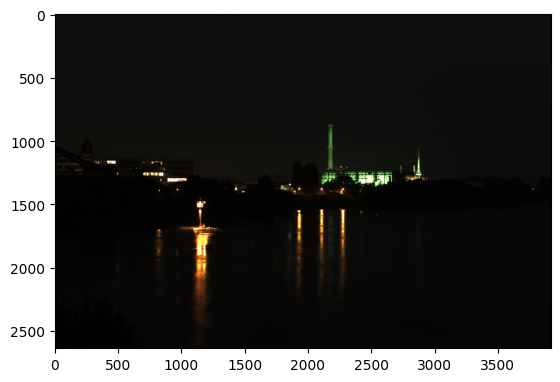

In [16]:
# # Step 3: Debayering (also called demosaicing)
# # TODO 3: Debayering. Complete the function debayering().
lin_rgb = debayering(balanced_bayer)
plt.imshow(lin_rgb)
plt.show()

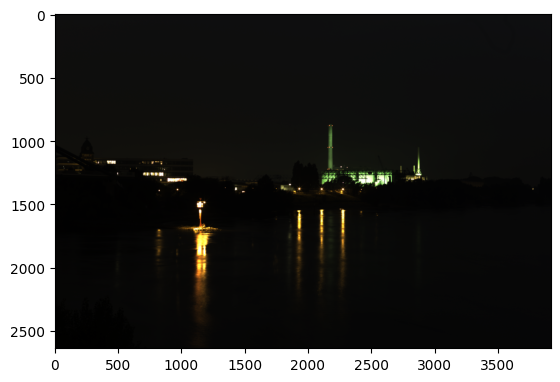

In [17]:
# # Step 4: Color space conversion --- we do this one for you.
# # Convert to sRGB. xyz2cam is found in dcraw's source file adobe_coeff.
rgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
           [0.2126729, 0.7151522, 0.0721750],
           [0.0193339, 0.1191920, 0.9503041]])
xyz2cam = np.array([[0.6653, -0.1486, -0.0611],
           [-0.4221, 1.3303, 0.0929],
           [-0.0881, 0.2416, 0.7226]])
rgb2cam = xyz2cam * rgb2xyz # Assuming previously defined matrices
denom = np.tile(np.reshape(np.sum(rgb2cam,axis=1),(3,-1)), (1,3))
rgb2cam = np.divide(rgb2cam, denom) # Normalize rows to 1
cam2rgb = np.linalg.inv(rgb2cam)
lin_srgb = apply_cmatrix(lin_rgb, cam2rgb)
lin_srgb[lin_srgb > 1.0] = 1.0 # Always keep image clipped b/w 0-1
lin_srgb[lin_srgb < 0.0] = 0.0
plt.imshow(lin_srgb)

In [ ]:
"""
    En esta seccion del codigo se transforma del espacio de color de la camara al espacio sRGB, aplicando
    una matriz 3x3 a cada pixel de la imagen.
    
    Esto se realiza debido a que despues del debayering, el color de la imagen se ve raro, porque los pixeles
    no estan en el espacio de color en el cual se los espera. 
"""

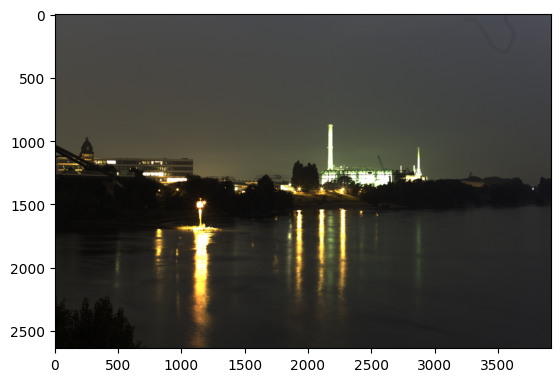

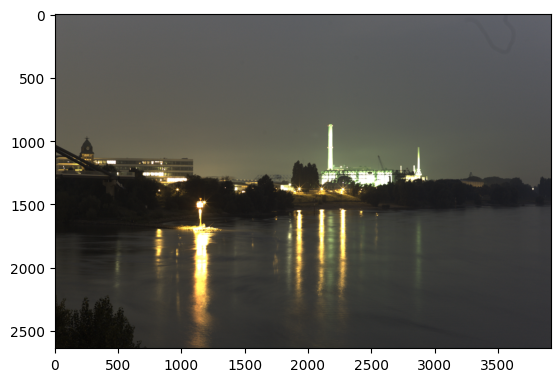

In [24]:
# # Step 5: Brightness and gamma correction
# # TODO: Brightness and gamma correction. Feel free to modify the consts.
# 1) Compute luminance
luminance = 0.2126 * lin_srgb[:,:,0] + 0.7152 * lin_srgb[:,:,1] + 0.0722 * lin_srgb[:,:,2]

# 2) Compute mean luminance
mean_lum = np.mean(luminance)

# 3) Target mean = 1/4 of maximum
target_mean = 0.25
alpha = target_mean / mean_lum

# 4) Apply brightness scaling
bright_srgb = lin_srgb * alpha
bright_srgb = np.clip(bright_srgb, 0, 1)
plt.imshow(bright_srgb)
plt.show()

# 5) Gamma correction
gamma = 1/1.25  # or any value
nl_srgb = np.power(bright_srgb, gamma)
nl_srgb = np.clip(nl_srgb, 0, 1)
plt.imshow(nl_srgb)
plt.show()

In [ ]:
"""
    En esta seccion se aplica la correccion de brillo y gamma a la imagen.
    
    Esto se realiza porque despues del debayering y la conversion de espacio de color, el color de la imagen
    esta bien pero sigue siendo muy oscura y para el ojo humano no se ve bien.
    
    Entonces aplicamos una correccion de brillo escalando todos los valores de la imagen por un factor alpha
    que se calcula en base a la luminancia media de la imagen y un valor objetivo 
    de luminancia media (target_mean).
    
    Luego de aplicar la correccion de brillo, los valores oscuros de la imagen siguen estando muy
    oscuros para el ojo humano, por lo que se aplica una correccion de gamma para ajustar la luminosidad
    de la imagen a una curva mas acorde a la percepcion humana, que se hace exponenciando los valores
    de la imagen por un valor gamma (en este caso 1/1.25). Este valor gamma es muy subjetivo y puede
    variar segun el gusto de cada persona.
"""